In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pascal_voc_writer

In [2]:
# train
!wget https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz

--2022-02-27 12:31:46--  https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz
Resolving mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)... 52.219.4.111
Connecting to mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)|52.219.4.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472626254 (1.4G) [application/x-tar]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   1.37G  19.7MB/s    in 73s     

2022-02-27 12:33:00 (19.2 MB/s) - ‘train.tar.gz’ saved [1472626254/1472626254]



In [ ]:
# unzipping the zipped file

!tar -xzvf  'train.tar.gz'

Streaming output truncated to the last 5000 lines.
train/Japan/annotations/xmls/Japan_009766.xml
train/Japan/annotations/xmls/Japan_006254.xml
train/Japan/annotations/xmls/Japan_008726.xml
train/Japan/annotations/xmls/Japan_004664.xml
train/Japan/annotations/xmls/Japan_007945.xml
train/Japan/annotations/xmls/Japan_006391.xml
train/Japan/annotations/xmls/Japan_005903.xml
train/Japan/annotations/xmls/Japan_008200.xml
train/Japan/annotations/xmls/Japan_003663.xml
train/Japan/annotations/xmls/Japan_001949.xml
train/Japan/annotations/xmls/Japan_011141.xml
train/Japan/annotations/xmls/Japan_003141.xml
train/Japan/annotations/xmls/Japan_002870.xml
train/Japan/annotations/xmls/Japan_008094.xml
train/Japan/annotations/xmls/Japan_007381.xml
train/Japan/annotations/xmls/Japan_012963.xml
train/Japan/annotations/xmls/Japan_007843.xml
train/Japan/annotations/xmls/Japan_004889.xml
train/Japan/annotations/xmls/Japan_011099.xml
train/Japan/annotations/xmls/Japan_003745.xml
train/Japan/annotations/xmls/

In [ ]:
# importing important libararies

import os
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
import cv2

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

def binder(base_path, country):
  '''
  This function is used to create two lists, one for containing all images and another for all annotations.
  Parameters : base_path - string and country - string 
  Return : two lists - all_images and all_annotations
  '''

  all_images = []
  all_annotations = []

  for each_image in sorted(os.listdir(base_path + country + '/' + 'images')):
    new_image_path = base_path + country + '/' + 'images' + '/' + each_image
    all_images.append(new_image_path)

  for each_xml in sorted(os.listdir(base_path + country + '/' + 'annotations' + '/' + 'xmls')):
    new_xml_path = base_path + country + '/' + 'annotations' + '/' + 'xmls' + '/' + each_xml
    all_annotations.append(new_xml_path)

  return all_images, all_annotations

In [ ]:
# collecting images and annotations corresponding to a particular country
czech_imgs, czech_annots = binder('train/', 'Czech')
india_imgs, india_annots = binder('train/', 'India')
japan_imgs, japan_annots = binder('train/', 'Japan')

# combining all the images and annotations
all_imgs = czech_imgs + india_imgs + japan_imgs
print(len(all_imgs))
print(all_imgs[:10])

print('*' * 50)

all_annots = czech_annots + india_annots + japan_annots
print(len(all_annots))
print(all_annots[:10])

21041
['train/Czech/images/Czech_000000.jpg', 'train/Czech/images/Czech_000001.jpg', 'train/Czech/images/Czech_000002.jpg', 'train/Czech/images/Czech_000006.jpg', 'train/Czech/images/Czech_000007.jpg', 'train/Czech/images/Czech_000009.jpg', 'train/Czech/images/Czech_000010.jpg', 'train/Czech/images/Czech_000011.jpg', 'train/Czech/images/Czech_000012.jpg', 'train/Czech/images/Czech_000013.jpg']
**************************************************
21041
['train/Czech/annotations/xmls/Czech_000000.xml', 'train/Czech/annotations/xmls/Czech_000001.xml', 'train/Czech/annotations/xmls/Czech_000002.xml', 'train/Czech/annotations/xmls/Czech_000006.xml', 'train/Czech/annotations/xmls/Czech_000007.xml', 'train/Czech/annotations/xmls/Czech_000009.xml', 'train/Czech/annotations/xmls/Czech_000010.xml', 'train/Czech/annotations/xmls/Czech_000011.xml', 'train/Czech/annotations/xmls/Czech_000012.xml', 'train/Czech/annotations/xmls/Czech_000013.xml']


In [ ]:
# creating a dataframe by taking images and annotations as features

dataset = pd.DataFrame({'images' : all_imgs, 'annotations' : all_annots})
dataset.head()

,images,annotations
0,train/Czech/images/Czech_000000.jpg,train/Czech/annotations/xmls/Czech_000000.xml
1,train/Czech/images/Czech_000001.jpg,train/Czech/annotations/xmls/Czech_000001.xml
2,train/Czech/images/Czech_000002.jpg,train/Czech/annotations/xmls/Czech_000002.xml
3,train/Czech/images/Czech_000006.jpg,train/Czech/annotations/xmls/Czech_000006.xml
4,train/Czech/images/Czech_000007.jpg,train/Czech/annotations/xmls/Czech_000007.xml


In [ ]:
# creating dataset related to Czech Republic
czech_dataset = dataset.loc[:2828]
czech_dataset.shape

(2829, 2)

In [ ]:
# creating dataset related to India
india_dataset = dataset.loc[2829:10534]
india_dataset.shape

(7706, 2)

In [ ]:
# creating dataset related to Japan
japan_dataset = dataset.loc[10535:]
japan_dataset.shape

(10506, 2)

In [ ]:
def filter_out_unused_labels(df):
  cleaned_indexes = []
  labels = []
  for i, row in df.iterrows():
    tree = ET.parse(row['annotations'])
    root = tree.getroot()

    for elem in root:
      for subelem in elem:
        if ('D00' in subelem.text) or ('D10' in subelem.text) or ('D20' in subelem.text) or ('D40' in subelem.text):
          labels.append(subelem.text)
          if i not in cleaned_indexes:
            cleaned_indexes.append(i)

  return cleaned_indexes, labels

In [ ]:
def generate_chart(labels, title):
  '''
  This function is used to create count plot.
  Reference : https://stackoverflow.com/questions/63603222/adding-percentages-to-sns-countplot-how-do-i-show-percentages-for-two-values-w
  Parameters : labels - numpy array, title - string
  Print : a countplot
  '''
  plt.figure(figsize=(7, 5))
  ax = sns.countplot(labels)
  plt.xticks(size=12)
  plt.xlabel('Damage Type', size=14)
  plt.yticks(size=12)
  plt.ylabel('Count', size=12)
  plt.title(title, size=16)

  total = len(labels)
  for p in ax.patches:
      percentage = f'{100 * p.get_height() / total:.3f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
  plt.tight_layout()
  plt.grid()

In [ ]:
czech_idx, czech_label = filter_out_unused_labels(czech_dataset)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


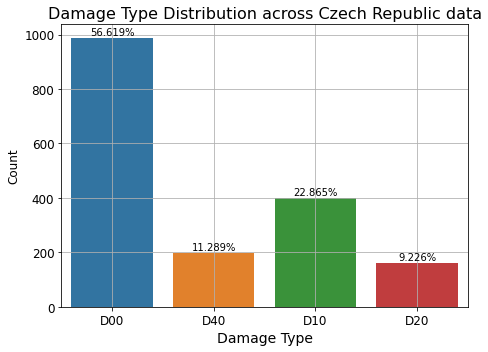

In [ ]:
# plotting countplot for Czech Republic data
generate_chart(czech_label, 'Damage Type Distribution across Czech Republic data')

In [ ]:
# getting indexes where damage types meet with the specified condition (Step - 1)

india_idx, india_label = filter_out_unused_labels(india_dataset)
print(len(india_idx))
print(len(india_label))

3223
6831


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


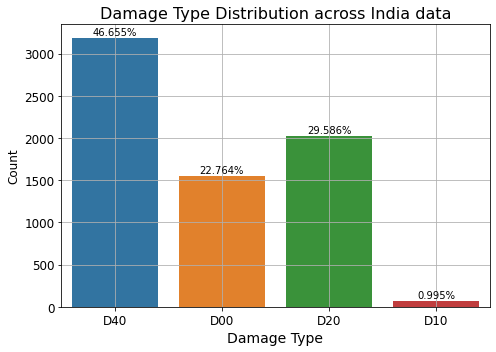

In [ ]:
# plotting countplot for India data
generate_chart(india_label, 'Damage Type Distribution across India data')

In [ ]:
# getting indexes where damage types meet with the specified condition (Step - 1)

japan_idx, japan_label = filter_out_unused_labels(japan_dataset)
print(len(japan_idx))
print(len(japan_label))

7900
16470


In [ ]:
# getting indexes where damage types meet with the specified condition (Step - 1)

idx, label = filter_out_unused_labels(dataset)
print(len(idx))
print(len(label))

12195
25046


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


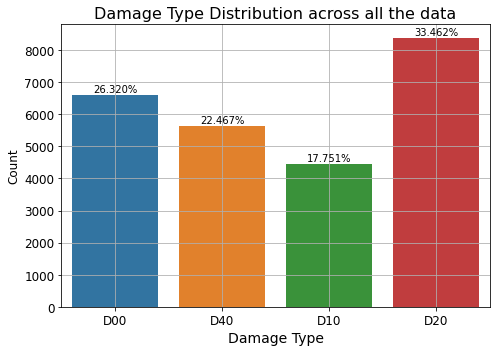

In [ ]:
# plotting countplot across all the data
generate_chart(label, 'Damage Type Distribution across all the data')

**New dataset**

In [ ]:
new_dataset = dataset.loc[idx]
new_dataset = new_dataset.reset_index(drop=True)
new_dataset.shape

(12195, 2)

In [ ]:
new_dataset.to_csv('/content/drive/My Drive/College/Thesis/RDD/final_dataset.csv', index=False)

In [ ]:
new_dataset.to_csv('final_dataset.csv', index=False)

**Augment dataset**

In [ ]:
import cv2

import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

import os
import sys
import time
import xml.etree.ElementTree as ET
from collections import defaultdict

import argparse
from pascal_voc_writer import Writer


class Augmentor(object):
    """Augmentor class to augment images for object detection task
    """
    
    def __init__(self, input_file="train.txt"):
        """init method
        
        Read the input file containing list of images to augment and bounding boxes of each image.
        
        Args:
            input_file (str): file containing paths to images
        
        """
        ia.seed(1)
        self.input_file = input_file
                
        # read inputfile
        self.bbox_dict = defaultdict(list)
        self.imgFiles = []
        self.aug = []
        with open(input_file,"r") as f:
            self.imgFiles = f.readlines()[1:]
            for i in range(len(self.imgFiles)):
                img_path = self.imgFiles[i].split(',')[0]
                self.imgFiles[i] = img_path.strip()
                assert(os.path.isfile(self.imgFiles[i]))
        print("total files:", len(self.imgFiles))
        
        # read bounding boxes for each image
        for img_file in self.imgFiles:
            xml_file = img_file.replace("images","annotations/xmls").rsplit(".",1)[0]+".xml"
            tree = ET.parse(xml_file)
            root = tree.getroot()

            #loop over each object tag in annotation tag
            for objects in root.findall('object'):
                surfaceType = objects.find('name').text
                bndbox = objects.find('bndbox')
                [minX,minY,maxX,maxY] = [int(child.text) for child in bndbox]
                self.bbox_dict[img_file].append([surfaceType, minX, minY, maxX, maxY])

    
    
    def readImages(self):
        """load images and attach bounding boxes associated witht that images in imgaug
        """
        #read image and attach bounding boxes associated with that image
        #this is required since we want to transform bounding boxes along with the image
        self.images_path = []
        self.bbs = []
        self.images = []
        for img in self.bbox_dict:
            ia_bbs = []
            for bbox in self.bbox_dict[img]:
                ia_bbs.append(ia.BoundingBox(x1=bbox[1], y1=bbox[2], x2=bbox[3], y2=bbox[4],label=bbox[0]))
            image = cv2.imread(img).astype(np.uint8)
            ia_bbs_for_image = ia.BoundingBoxesOnImage(ia_bbs, shape=image.shape)
            self.images_path.append(img)
            self.images.append(image)
            self.bbs.append(ia_bbs_for_image)

    def addAugmentor(self, augmentor):
        """adds augmentor to current list of augmentors
        
        User can add any number of "imgaug.augmenters" objects, these are the
        transformations that will be applied to images and bounding boxes
        
        Args:
            augmentor (:obj:augmenters): imgaug.augmenters object
        
        """
        self.aug.append(augmentor)
        
    def augment(self):
        """augment all images with augmentor and save augmented images and XML files
        """
        for i in range(len(self.aug)):
            self.aug[i] = self.aug[i].to_deterministic()

        images_aug = []
        bbs_aug = []
        for i in range(len(self.aug)):
            print("augmentor:",i)
            images_aug = self.aug[i].augment_images(self.images)
            bbs_aug = self.aug[i].augment_bounding_boxes(self.bbs)
            for j in range(len(bbs_aug)):
                bbs_aug[j] = bbs_aug[j].remove_out_of_image().cut_out_of_image()
            print(len(images_aug))
            for k in range(len(images_aug)):
                writer = Writer(self.images_path[k], images_aug[k].shape[1], images_aug[k].shape[0])
                for l in range(len(bbs_aug[k].bounding_boxes)):
                    after = bbs_aug[k].bounding_boxes[l]
                    writer.addObject(after.label, int(after.x1),int(after.y1),int(after.x2),int(after.y2))       
                xml_path = self.images_path[k].replace("images","Augmented_dataset")
                print(xml_path)
                xml_path = xml_path.rsplit('.',1)[0]
                if i==0 and (not os.path.isdir(xml_path)):
                    os.makedirs(xml_path)
                xml_file_name = os.path.basename(self.images_path[k]).rsplit(".",1)[0]+"_"+str(i+3)+"_aug.xml"
                xml_file = os.path.join(xml_path,xml_file_name)
                jpeg_file = xml_file.rsplit(".",1)[0]+"."+self.images_path[k].rsplit(".",1)[1]
                writer.save(xml_file)
                cv2.imwrite(jpeg_file,images_aug[k])    

In [ ]:
A = Augmentor("final_dataset.csv")
A.readImages()
A.addAugmentor(iaa.Sharpen(alpha=(0.0, 0.25), lightness=(0.75, 1.5)))
A.addAugmentor(iaa.Multiply((0.75, 1.25)))
A.addAugmentor(iaa.AdditiveGaussianNoise(scale=(10, 50)))
A.augment()

total files: 12195
augmentor: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: DeprecationWarning: Method `BoundingBoxesOnImage.cut_out_of_image()` is deprecated. Use `BoundingBoxesOnImage.clip_out_of_image()` instead. clip_out_of_image() has the exactly same interface.


Streaming output truncated to the last 5000 lines.
train/Japan/Augmented_dataset/Japan_004829.jpg
train/Japan/Augmented_dataset/Japan_004830.jpg
train/Japan/Augmented_dataset/Japan_004831.jpg
train/Japan/Augmented_dataset/Japan_004834.jpg
train/Japan/Augmented_dataset/Japan_004835.jpg
train/Japan/Augmented_dataset/Japan_004836.jpg
train/Japan/Augmented_dataset/Japan_004839.jpg
train/Japan/Augmented_dataset/Japan_004840.jpg
train/Japan/Augmented_dataset/Japan_004841.jpg
train/Japan/Augmented_dataset/Japan_004843.jpg
train/Japan/Augmented_dataset/Japan_004846.jpg
train/Japan/Augmented_dataset/Japan_004847.jpg
train/Japan/Augmented_dataset/Japan_004849.jpg
train/Japan/Augmented_dataset/Japan_004851.jpg
train/Japan/Augmented_dataset/Japan_004853.jpg
train/Japan/Augmented_dataset/Japan_004854.jpg
train/Japan/Augmented_dataset/Japan_004856.jpg
train/Japan/Augmented_dataset/Japan_004857.jpg
train/Japan/Augmented_dataset/Japan_004858.jpg
train/Japan/Augmented_dataset/Japan_004861.jpg
train/Jap

In [ ]:
def draw_bb(image_file, xml_file):
  '''
  This function is used to create bounding boxes and putting text(label) on the image, based on annotations.
  Reference : https://github.com/sekilab/RoadDamageDetector/blob/master/RoadDamageDatasetTutorial.ipynb
  Parameters : image_file - string, xml_file - string
  Return : img - a image
  '''
  img = cv2.imread(image_file)
  infile_xml = open(xml_file)
  tree = ET.parse(infile_xml)
  root = tree.getroot()

  for obj in root.iter('object'):
    cls_name = obj.find('name').text
    if ('D00' in cls_name) or ('D10' in cls_name) or ('D20' in cls_name) or ('D40' in cls_name):
      xmlbox = obj.find('bndbox')
      xmin = int(xmlbox.find('xmin').text)
      xmax = int(xmlbox.find('xmax').text)
      ymin = int(xmlbox.find('ymin').text)
      ymax = int(xmlbox.find('ymax').text)

      font = cv2.FONT_HERSHEY_SIMPLEX

      # put text
      cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

      # draw bounding box
      cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)

  return img

Sample Augmented Images

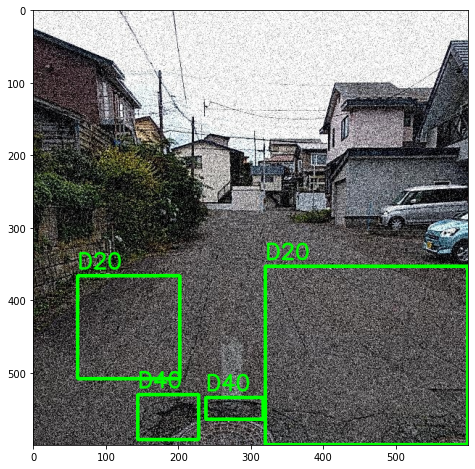

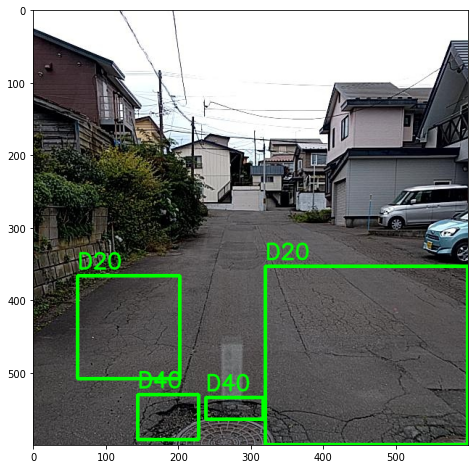

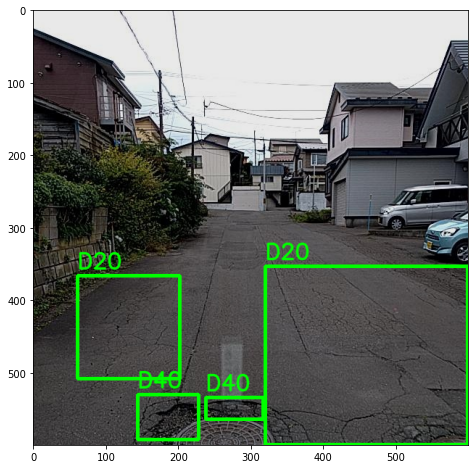

In [ ]:
import glob
for filename in glob.glob('/content/train/Japan/Augmented_dataset/Japan_000017' + '/*.jpg'):
  img = draw_bb(filename, filename.split('.')[0] + '.xml')
  plt.figure(figsize=(12,8))
  plt.subplot(1,1,1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

Original Image

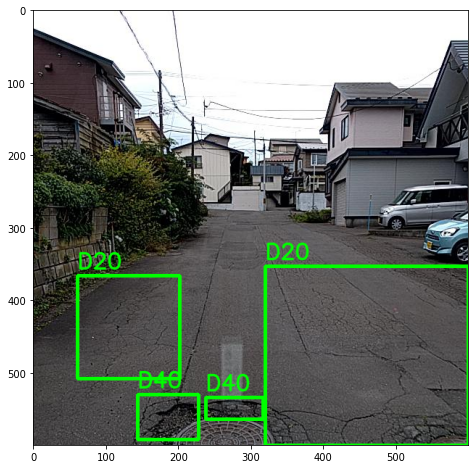

In [ ]:
img = draw_bb('/content/train/Japan/images/Japan_000017.jpg', '/content/train/Japan/annotations/xmls/Japan_000017.xml')
plt.figure(figsize=(12,8))
plt.subplot(1,1,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

**Convert annotations**

In [ ]:
from IPython.core.interactiveshell import no_op

import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join


classes = ['D00', 'D10', 'D20', 'D40']

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path, annotation_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]
    
    try:

        in_file = open(annotation_path)
        out_file = open(output_path + basename_no_ext + '.txt', 'w')
        
        tree = ET.parse(in_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        object_a = root.find('object')

        for obj in root.iter('object'):
            difficult = obj.find('difficult')
            cls = obj.find('name').text
            if cls not in classes or (difficult is not None and int(difficult.text)==1):
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert((w,h), b)
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

    except FileNotFoundError:
      print('Failed for ' + output_path + basename_no_ext + '.txt')


In [ ]:
!mkdir -p /content/train/annotations

In [ ]:
!pwd

/content


In [ ]:
imgFiles = []
cwd = getcwd()
output_path = cwd + '/train/annotations/'
print(output_path)
with open('final_dataset.csv',"r") as f:
    imgFiles = f.readlines()
    for i in range(len(imgFiles)):
        file_paths = imgFiles[i].split(',')
        convert_annotation('', output_path, file_paths[0].strip(), file_paths[1].strip())

/content/train/annotations/
Failed for /content/train/annotations/images.txt


In [ ]:
!ls train/annotations/ | wc -l

12195


Merge Text Files together

In [ ]:
filenames = ['Czech.txt', 'India.txt', 'Japan.txt']
with open('train.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [ ]:
import pandas as pd
final_dataset = pd.read_csv('train.txt', sep=" ", header=None)
final_dataset.head()
final_dataset.shape

(21041, 1)

In [ ]:
%cd train
!mkdir images

/content/train


In [ ]:
%cd ..

/content


In [ ]:
!pwd

/content


In [ ]:
!mv -v train/Czech/images/* train/images/


renamed 'train/Czech/images/Czech_000000.jpg' -> 'train/images/Czech_000000.jpg'
renamed 'train/Czech/images/Czech_000001.jpg' -> 'train/images/Czech_000001.jpg'
renamed 'train/Czech/images/Czech_000002.jpg' -> 'train/images/Czech_000002.jpg'
renamed 'train/Czech/images/Czech_000006.jpg' -> 'train/images/Czech_000006.jpg'
renamed 'train/Czech/images/Czech_000007.jpg' -> 'train/images/Czech_000007.jpg'
renamed 'train/Czech/images/Czech_000009.jpg' -> 'train/images/Czech_000009.jpg'
renamed 'train/Czech/images/Czech_000010.jpg' -> 'train/images/Czech_000010.jpg'
renamed 'train/Czech/images/Czech_000011.jpg' -> 'train/images/Czech_000011.jpg'
renamed 'train/Czech/images/Czech_000012.jpg' -> 'train/images/Czech_000012.jpg'
renamed 'train/Czech/images/Czech_000013.jpg' -> 'train/images/Czech_000013.jpg'
renamed 'train/Czech/images/Czech_000014.jpg' -> 'train/images/Czech_000014.jpg'
renamed 'train/Czech/images/Czech_000015.jpg' -> 'train/images/Czech_000015.jpg'
renamed 'train/Czech/images/

In [ ]:
!mv -v train/India/images/* train/images/

Streaming output truncated to the last 5000 lines.
renamed 'train/India/images/India_003469.jpg' -> 'train/images/India_003469.jpg'
renamed 'train/India/images/India_003471.jpg' -> 'train/images/India_003471.jpg'
renamed 'train/India/images/India_003472.jpg' -> 'train/images/India_003472.jpg'
renamed 'train/India/images/India_003473.jpg' -> 'train/images/India_003473.jpg'
renamed 'train/India/images/India_003475.jpg' -> 'train/images/India_003475.jpg'
renamed 'train/India/images/India_003478.jpg' -> 'train/images/India_003478.jpg'
renamed 'train/India/images/India_003479.jpg' -> 'train/images/India_003479.jpg'
renamed 'train/India/images/India_003480.jpg' -> 'train/images/India_003480.jpg'
renamed 'train/India/images/India_003481.jpg' -> 'train/images/India_003481.jpg'
renamed 'train/India/images/India_003482.jpg' -> 'train/images/India_003482.jpg'
renamed 'train/India/images/India_003483.jpg' -> 'train/images/India_003483.jpg'
renamed 'train/India/images/India_003485.jpg' -> 'train/im

In [ ]:

!mv -v train/Japan/images/* train/images/

Streaming output truncated to the last 5000 lines.
renamed 'train/Japan/images/Japan_006896.jpg' -> 'train/images/Japan_006896.jpg'
renamed 'train/Japan/images/Japan_006897.jpg' -> 'train/images/Japan_006897.jpg'
renamed 'train/Japan/images/Japan_006898.jpg' -> 'train/images/Japan_006898.jpg'
renamed 'train/Japan/images/Japan_006899.jpg' -> 'train/images/Japan_006899.jpg'
renamed 'train/Japan/images/Japan_006900.jpg' -> 'train/images/Japan_006900.jpg'
renamed 'train/Japan/images/Japan_006901.jpg' -> 'train/images/Japan_006901.jpg'
renamed 'train/Japan/images/Japan_006903.jpg' -> 'train/images/Japan_006903.jpg'
renamed 'train/Japan/images/Japan_006904.jpg' -> 'train/images/Japan_006904.jpg'
renamed 'train/Japan/images/Japan_006905.jpg' -> 'train/images/Japan_006905.jpg'
renamed 'train/Japan/images/Japan_006908.jpg' -> 'train/images/Japan_006908.jpg'
renamed 'train/Japan/images/Japan_006909.jpg' -> 'train/images/Japan_006909.jpg'
renamed 'train/Japan/images/Japan_006910.jpg' -> 'train/im

In [ ]:
annotation_files = os.listdir('train/annotations')

df = pd.DataFrame(annotation_files, columns=['annotations'])

In [ ]:
df.shape

(12195, 1)

In [ ]:
df["images"] = df["annotations"]


In [ ]:
for row in df.itertuples():
  df.at[row.Index, 'images'] = os.path.splitext(df.at[row.Index, 'images'])[0] + '.jpg'

In [ ]:

df =df.sort_values('annotations')


In [ ]:
df.head()

,annotations,images
8134,Czech_000006.txt,Czech_000006.jpg
1294,Czech_000010.txt,Czech_000010.jpg
8556,Czech_000020.txt,Czech_000020.jpg
4257,Czech_000021.txt,Czech_000021.jpg
753,Czech_000022.txt,Czech_000022.jpg


In [ ]:
from sklearn.model_selection import train_test_split

# performing traditional 80:20 split
train, val = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train.shape

(9756, 2)

In [ ]:
val.shape

(2439, 2)

In [ ]:
!mkdir -p data/images/train
!mkdir -p data/images/valid
!mkdir -p data/labels/valid
!mkdir -p data/labels/train

In [ ]:
!mv train/label_map.pbtxt data

In [ ]:
import shutil

for row in train.itertuples():
  shutil.move('train/images/' +df.at[row.Index, 'images'], 'data/images/train/' + df.at[row.Index, 'images'])
  shutil.move('train/annotations/' +df.at[row.Index, 'annotations'], 'data/labels/train/' + df.at[row.Index, 'annotations'])


In [ ]:
import shutil

for row in val.itertuples():
  shutil.move('train/images/' +df.at[row.Index, 'images'], 'data/images/valid/' + df.at[row.Index, 'images'])
  shutil.move('train/annotations/' +df.at[row.Index, 'annotations'], 'data/labels/valid/' + df.at[row.Index, 'annotations'])

In [ ]:
!ls data/images/train | wc -l
!ls data/images/valid | wc -l

9756
2439


In [ ]:
!touch obj.data

In [ ]:
!touch obj.names

In [ ]:
!touch data.yaml

In [ ]:
!cp obj.data ./data

In [ ]:
!cp obj.names ./data
!cp data.yaml ./data

In [ ]:
%cd data

/content/data


In [ ]:
import glob

image_list = []
for filename in glob.glob('images/train' + '/*.jpg'):
  image_list.append('images/train' + filename)

In [ ]:
with open('train.txt', 'w') as f:
    for item in image_list:
        f.write("%s\n" % item)

In [ ]:
image_list = []
for filename in glob.glob('images/valid' + '/*.jpg'):
  image_list.append('images/valid' + filename)

In [ ]:
with open('valid.txt', 'w') as f:
    for item in image_list:
        f.write("%s\n" % item)

In [ ]:
%cd ..

/content


In [ ]:
import tarfile

def make_tarfile(output_filename, source_dir):
  '''
  This function is used to create tar.gz file for a given folder.
  Input : output file name (string) and source directory (string)
  '''
  # Reference : https://stackoverflow.com/questions/2032403/how-to-create-full-compressed-tar-file-using-python
  with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(source_dir)

In [ ]:
# function calling for creating tar.gz file
make_tarfile('RDD2020_yolo_data.tar.gz', '/content/data')

In [ ]:
!ls -lh

total 2.3G
drwxr-xr-x 4 root root 4.0K Feb  2 20:30 data
-rw-r--r-- 1 root root    0 Feb  2 20:29 data.yaml
drwx------ 6 root root 4.0K Feb  2 20:20 drive
-rw-r--r-- 1 root root 977K Feb  2 20:25 final_dataset.csv
-rw-r--r-- 1 root root    0 Feb  2 20:29 obj.data
-rw-r--r-- 1 root root    0 Feb  2 20:29 obj.names
-rw-r--r-- 1 root root 849M Feb  2 20:32 RDD2020_yolo_data.tar.gz
drwxr-xr-x 1 root root 4.0K Feb  1 14:32 sample_data
drwxrwxr-x 7 1000 1000 4.0K Feb  2 20:29 train
-rw-r--r-- 1 root root 1.4G May 11  2020 train.tar.gz


In [ ]:
%cp RDD2020_yolo_data.tar.gz /content/drive/MyDrive/College/Thesis/RDD/

Augmented Dataset

In [ ]:
!mkdir -p aug_data/images/train
!mkdir -p aug_data/images/valid
!mkdir -p aug_data/labels/valid
!mkdir -p aug_data/labels/train

In [ ]:
def bind_augmented_annotations_and_images(base_path, country):
  '''
  This function is used to create two lists, one for containing all images and another for all annotations.
  Parameters : base_path - string and country - string 
  Return : two lists - all_images and all_annotations
  '''

  all_images = []
  all_annotations = []

  for folder in sorted(os.listdir(base_path + country + '/' + 'Augmented_dataset')):
    for image in glob.glob(base_path + country + '/' + 'Augmented_dataset/' + folder + '/*.jpg'):
      all_images.append(image)
    for xml in glob.glob(base_path + country + '/' + 'Augmented_dataset/' + folder + '/*.xml'):
      all_annotations.append(xml)

  return all_images, all_annotations

In [ ]:
# collecting augmented images and annotations corresponding to a particular country
czech_aug_imgs, czech_aug_annots = bind_augmented_annotations_and_images('train/', 'Czech')
india_aug_imgs, india_aug_annots = bind_augmented_annotations_and_images('train/', 'India')
japan_aug_imgs, japan_aug_annots = bind_augmented_annotations_and_images('train/', 'Japan')

# combining all the images and annotations
all_aug_imgs = czech_aug_imgs + india_aug_imgs + japan_aug_imgs
print(len(all_aug_imgs))
print(all_aug_imgs[:10])

print('*' * 50)

all_aug_annots = czech_aug_annots + india_aug_annots + japan_aug_annots
print(len(all_aug_annots))
print(all_aug_annots[:10])

36585
['train/Czech/Augmented_dataset/Czech_000006/Czech_000006_3_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000006/Czech_000006_5_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000006/Czech_000006_4_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000010/Czech_000010_3_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000010/Czech_000010_5_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000010/Czech_000010_4_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000020/Czech_000020_3_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000020/Czech_000020_4_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000020/Czech_000020_5_aug.jpg', 'train/Czech/Augmented_dataset/Czech_000021/Czech_000021_3_aug.jpg']
**************************************************
36585
['train/Czech/Augmented_dataset/Czech_000006/Czech_000006_5_aug.xml', 'train/Czech/Augmented_dataset/Czech_000006/Czech_000006_3_aug.xml', 'train/Czech/Augmented_dataset/Czech_000006/Czech_000006_4_aug.xml', 'train/Czech/Augmented_dataset/Czech_0

In [ ]:
import pandas as pd

aug_df = pd.DataFrame({
    'images': all_aug_imgs,
    'annotations': all_aug_annots
})

In [ ]:
aug_df.head()

,images,annotations
0,train/Czech/Augmented_dataset/Czech_000006/Cze...,train/Czech/Augmented_dataset/Czech_000006/Cze...
1,train/Czech/Augmented_dataset/Czech_000006/Cze...,train/Czech/Augmented_dataset/Czech_000006/Cze...
2,train/Czech/Augmented_dataset/Czech_000006/Cze...,train/Czech/Augmented_dataset/Czech_000006/Cze...
3,train/Czech/Augmented_dataset/Czech_000010/Cze...,train/Czech/Augmented_dataset/Czech_000010/Cze...
4,train/Czech/Augmented_dataset/Czech_000010/Cze...,train/Czech/Augmented_dataset/Czech_000010/Cze...


In [ ]:
from sklearn.model_selection import train_test_split

# performing traditional 80:20 split
aug_train, aug_val = train_test_split(aug_df, test_size=0.2, random_state=42)

In [ ]:
aug_train.shape

(29268, 2)

In [ ]:
aug_val.shape

(7317, 2)

In [ ]:
import shutil
#move train files
for row in aug_train.itertuples():
  shutil.move(aug_train.at[row.Index, 'images'], 'aug_data/images/train/' + os.path.basename(aug_train.at[row.Index, 'images']))
  shutil.move(aug_train.at[row.Index, 'annotations'], 'aug_data/labels/train/' + os.path.basename(aug_train.at[row.Index, 'annotations']))

In [ ]:
!ls /content/aug_data/labels/train | wc -l

29268


In [ ]:
import shutil
#move val files
for row in aug_val.itertuples():
  shutil.move(aug_val.at[row.Index, 'images'], 'aug_data/images/valid/' + os.path.basename(aug_val.at[row.Index, 'images']))
  shutil.move(aug_val.at[row.Index, 'annotations'], 'aug_data/labels/valid/' + os.path.basename(aug_val.at[row.Index, 'annotations']))

In [ ]:
!ls /content/aug_data/labels/valid | wc -l

7317


In [ ]:
def get_annotatins_in_dir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.xml'):
        image_list.append(filename)

    return image_list


def convert_aug_annotation(output_path, annotation_path):
    basename = os.path.basename(annotation_path)
    basename_no_ext = os.path.splitext(basename)[0]
    
    try:

        in_file = open(annotation_path)
        out_file = open(output_path + '/' + basename_no_ext + '.txt', 'w')
        
        tree = ET.parse(in_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        object_a = root.find('object')

        for obj in root.iter('object'):
            difficult = obj.find('difficult')
            cls = obj.find('name').text
            if cls not in classes or (difficult is not None and int(difficult.text)==1):
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert((w,h), b)
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

    except FileNotFoundError:
      print('Failed for ' + output_path + basename_no_ext + '.txt')


In [ ]:

cwd = getcwd()
dir_path = cwd + '/aug_data'
output_path = '/content/aug_data/labels/train'
image_path = '/content/aug_data/images/train'
image_paths = get_annotatins_in_dir('/content/aug_data/labels/train')



for image_path in image_paths:
  basename = os.path.basename(image_path)
  basename_no_ext = os.path.splitext(basename)[0]
  convert_aug_annotation(output_path, image_path)


    #print("Finished processing: " + dir_path)

In [ ]:

cwd = getcwd()
dir_path = cwd + '/aug_data'
output_path = '/content/aug_data/labels/valid'
image_path = '/content/aug_data/images/valid'
image_paths = get_annotatins_in_dir('/content/aug_data/labels/valid')



for image_path in image_paths:
  basename = os.path.basename(image_path)
  basename_no_ext = os.path.splitext(basename)[0]

  convert_aug_annotation(output_path, image_path)


In [ ]:
!ls /content/aug_data/labels/train | wc -l

2


In [ ]:
!pwd

/content/aug_data/labels/valid


In [ ]:
%cd ../..

/content/aug_data


In [ ]:
image_list = []
for filename in glob.glob('images/valid' + '/*.jpg'):
  image_list.append(filename)



In [ ]:
with open('valid.txt', 'w') as f:
    for item in image_list:
        f.write("%s\n" % item)

In [ ]:
image_list = []
for filename in glob.glob('images/train' + '/*.jpg'):
  image_list.append(filename)

In [ ]:
with open('train.txt', 'w') as f:
    for item in image_list:
        f.write("%s\n" % item)

In [ ]:
!touch data.yaml

In [ ]:
!touch obj.data

In [ ]:
!touch obj.names

In [ ]:
%cd ..

/content


In [ ]:
# function calling for creating tar.gz file
make_tarfile('RDD2020_yolo_aug_data.tar.gz', './aug_data/')

In [ ]:
!ls -hl RDD2020_yolo_aug_data.tar.gz

-rw-r--r-- 1 root root 7.0G Jan 29 11:48 RDD2020_yolo_aug_data.tar.gz


In [ ]:
%cp RDD2020_yolo_aug_data.tar.gz /content/drive/MyDrive/College/Thesis/RDD/